In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

import xgboost as xgb 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import yellowbrick.model_selection as ms

In [157]:
landsat_training_data = pd.read_csv('../Datasets/landsat_features_more_bands_train.csv')
terra_climate_training_data = pd.read_csv('../Datasets/terraclimate_features_more_bands_training.csv')
precipitation_training_data = pd.read_csv('../Datasets/nasa_precip_features_training.csv')
soil_use_training_data = pd.read_csv('../Datasets/soil_use_data_training.csv')
terrain_training_data = pd.read_csv('../Datasets/nasa_terrain_features_training.csv')

explained_variables = pd.read_csv('../Datasets/water_quality_training_dataset.csv')

full_dataset = combine_two_datasets(landsat_training_data, terra_climate_training_data)
full_dataset = combine_two_datasets(full_dataset, precipitation_training_data)
full_dataset = combine_two_datasets(full_dataset, soil_use_training_data)
full_dataset = combine_two_datasets(full_dataset, terrain_training_data)

print(full_dataset.columns)

full_dataset = combine_two_datasets(full_dataset, explained_variables)
full_dataset

Index(['Latitude', 'Longitude', 'Sample Date', 'nir', 'green', 'swir16',
       'swir22', 'coastal', 'blue', 'red', 'lwir11', 'NDMI', 'MNDWI',
       'Clorfilia', 'Turbidity', 'NDTI', 'NDVI', 'q', 'ppt', 'pet', 'soil',
       'pdsi', 'tmax', 'tmin', 'Saline_Index', 'Runoff_Ratio',
       'Chemical_Solubility', 'rain_7d_nasa', 'rain_3d_nasa', 'rain_12d_nasa',
       'pct_agri', 'pct_urban', 'pct_natural', 'pct_water', 'pct_wetlands',
       'pct_others', 'elevation', 'slope', 'curvature'],
      dtype='object')


,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,coastal,blue,red,...,pct_natural,pct_water,pct_wetlands,pct_others,elevation,slope,curvature,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-28.760833,17.730278,2011-01-02,11190.0,11426.0,7687.5,7645.0,NaN,9557.0,12802.0,...,12.073306,12.318655,0.0,75.608039,164.0,10.046788,0.003889,128.912,555.0,10.0
1,-26.861111,28.884722,2011-01-03,17658.5,9550.0,13746.5,10574.0,NaN,8691.0,9241.5,...,55.248572,0.157149,0.0,0.000000,1519.0,2.698951,0.002222,74.720,162.9,163.0
2,-26.450000,28.085833,2011-01-03,15210.0,10720.0,17974.0,14201.0,NaN,9502.5,12540.0,...,59.443587,4.880401,0.0,0.015003,1472.0,2.698951,-0.000833,89.254,573.0,80.0
3,-27.671111,27.236944,2011-01-03,22506.5,17609.5,19994.0,18637.0,NaN,16789.5,17986.5,...,47.679925,4.253647,0.0,0.715666,1338.0,3.016961,0.004722,82.000,203.6,101.0
4,-27.356667,27.286389,2011-01-03,16828.5,9502.5,12665.5,9643.0,NaN,NaN,NaN,...,65.740741,0.006400,0.0,0.002133,1356.0,4.763642,-0.000556,56.100,145.1,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9314,-27.527500,30.858056,2015-12-23,15296.5,10043.0,16381.0,14443.0,8671.5,8983.0,10596.5,...,90.399386,0.100273,0.0,0.317887,957.0,5.128712,-0.000278,38.900,134.0,20.0
9315,-26.861111,28.884722,2015-12-23,15642.5,10294.5,17045.5,14710.0,8885.0,9301.0,10760.0,...,55.248572,0.157149,0.0,0.000000,1519.0,2.698951,0.002222,115.800,388.0,20.0
9316,-26.984722,26.632278,2015-12-23,14945.0,10732.0,18303.0,16281.0,NaN,9793.0,11721.5,...,52.152307,0.008495,0.0,0.080698,1284.0,2.134300,-0.003333,104.874,835.0,148.0
9317,-27.935000,26.126667,2015-12-23,14727.5,11051.0,18420.0,15724.5,NaN,9881.5,12074.0,...,70.994084,0.289352,0.0,0.437243,1248.0,5.385977,0.000278,128.000,305.0,28.0


In [ ]:

#adicionando caracteristicas temporais cíclicas para o modelo
full_dataset['Sample Date'] = pd.to_datetime(full_dataset['Sample Date'], dayfirst=True, format="%Y-%m-%d")

#full_dataset['WeekOfYear'] = full_dataset['Sample Date'].dt.isocalendar().week.astype(int)
full_dataset['MonthOfYear'] = full_dataset['Sample Date'].dt.month

#MAX_CYCLE = 52
MAX_CYCLE_MONTH = 12

#full_dataset['WOY_sin'] = np.sin(2 * np.pi * full_dataset['WeekOfYear'] / MAX_CYCLE)
#full_dataset['WOY_cos'] = np.cos(2 * np.pi * full_dataset['WeekOfYear'] / MAX_CYCLE)
full_dataset['Month_sin'] = np.sin(2 * np.pi * full_dataset['MonthOfYear'] / MAX_CYCLE_MONTH)
full_dataset['Month_cos'] = np.cos(2 * np.pi * full_dataset['MonthOfYear'] / MAX_CYCLE_MONTH)


target_columns = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

feature_columns = full_dataset.columns.drop(target_columns + ['Latitude', 'Longitude', 'Sample Date', "MonthOfYear"])


#choosing feature data and target data
Feature_data = full_dataset[feature_columns]
Target_data = full_dataset[target_columns]

alkalinity_target = full_dataset['Total Alkalinity']
electrical_target = full_dataset['Electrical Conductance']
phosphorus_target = full_dataset['Dissolved Reactive Phosphorus']

X_train_alkalinity, X_test_alkalinity, y_train_alkalinity, y_test_alkalinity = train_test_split(Feature_data, alkalinity_target, test_size=0.15)
X_train_electrical, X_test_electrical, y_train_electrical, y_test_electrical = train_test_split(Feature_data, electrical_target, test_size=0.15)
X_train_phosphorus, X_test_phosphorus, y_train_phosphorus, y_test_phosphorus = train_test_split(Feature_data, phosphorus_target, test_size=0.15)

X_train_alkalinity


,green,MNDWI,NDMI,rain_7d_nasa,slope,pct_agri,pct_urban,q,pdsi,swir22,Chemical_Solubility
7420,10165.5,-0.180681,0.026693,0.92,1.350224,8.169636,10.660664,0.7,-3.49,12137.5,27.125000
2317,9669.0,-0.050126,0.036374,0.85,11.348120,0.000000,0.004267,3.5,1.19,9297.5,24.975000
5019,10560.0,-0.220707,-0.007845,27.20,1.350224,0.331288,0.000000,3.7,0.99,13610.5,26.810000
1162,10443.0,-0.225943,-0.102707,8.81,4.763642,3.595320,0.840961,4.5,-2.89,13423.5,23.570000
784,8522.5,0.037116,0.029469,0.28,0.000000,11.992185,0.297309,2.7,-2.43,7778.0,23.345000
...,...,...,...,...,...,...,...,...,...,...,...
1731,9392.0,-0.138586,0.092063,21.07,2.134300,9.525943,11.247653,6.7,-1.55,10009.0,22.605000
2343,9625.0,-0.249074,-0.071476,0.09,3.931096,4.687500,2.970679,6.5,-0.80,12880.0,23.255000
1703,10329.0,-0.200403,-0.024986,4.02,1.909152,20.042897,0.027607,0.6,0.76,12457.5,23.189999
71,NaN,NaN,NaN,38.94,5.550718,33.781362,0.202680,5.4,3.74,NaN,18.225000


## Learning Curve ( see overfitting )

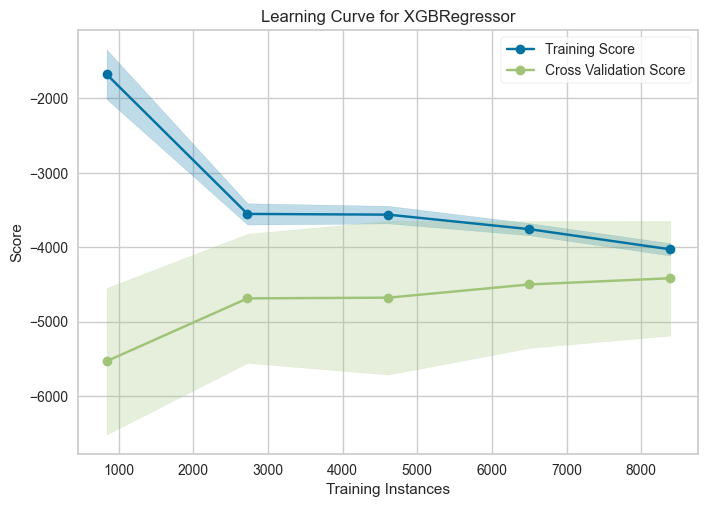

In [ ]:
_ = ms.learning_curve(boost_predicter, Feature_data, Target_data, scoring='neg_mean_squared_error', cv=5)

## Feature Importance

In [163]:
dart_xgb_alcalinity= xgb.XGBRegressor(objective ='reg:squarederror',
                            booster='dart',
                            learning_rate = 0.05, # bom
                            max_depth = 4, # bom, muda comforme adicionar dados 
                            n_estimators = 70, # bom, muda conforme adicionar dados
                            subsample = 0.6,
                            colsample_bytree = 0.5,
                            min_child_weight=12.0, ## fixado assim, bom
                            gamma=1.0,  ## fixado assim, bom
                            verbosity = 1,
                            rate_drop = 0.25, # bom : 0.25
                            skip_drop = 0.5 # bom : 0.5
)

dart_xgb_electrical= xgb.XGBRegressor(objective ='reg:squarederror',
                            booster='dart',
                            learning_rate = 0.05, # bom
                            max_depth = 4, # bom, muda comforme adicionar dados 
                            n_estimators = 70, # bom, muda conforme adicionar dados
                            subsample = 0.6,
                            colsample_bytree = 0.5,
                            min_child_weight=12.0, ## fixado assim, bom
                            gamma=1.0,  ## fixado assim, bom
                            verbosity = 1,
                            rate_drop = 0.25, # bom : 0.25
                            skip_drop = 0.5 # bom : 0.5
)

dart_xgb_phosphorus= xgb.XGBRegressor(objective ='reg:squarederror',
                            booster='dart',
                            learning_rate = 0.05, # bom
                            max_depth = 4, # bom, muda comforme adicionar dados 
                            n_estimators = 70, # bom, muda conforme adicionar dados
                            subsample = 0.6,
                            colsample_bytree = 0.5,
                            min_child_weight=12.0, ## fixado assim, bom
                            gamma=1.0,  ## fixado assim, bom
                            verbosity = 1,
                            rate_drop = 0.25, # bom : 0.25
                            skip_drop = 0.5 # bom : 0.5
)

# parametros treino:

dart_xgb_alcalinity.fit(X_train_alkalinity, y_train_alkalinity,
            eval_set=[(X_test_alkalinity, y_test_alkalinity)])


[0]	validation_0-rmse:72.62604
[1]	validation_0-rmse:71.80741
[2]	validation_0-rmse:70.72111
[3]	validation_0-rmse:69.81994
[4]	validation_0-rmse:68.96492


[5]	validation_0-rmse:68.28654
[6]	validation_0-rmse:67.31672
[7]	validation_0-rmse:66.96107
[8]	validation_0-rmse:66.21045
[9]	validation_0-rmse:65.72645
[10]	validation_0-rmse:64.98822
[11]	validation_0-rmse:64.43407
[12]	validation_0-rmse:63.84585
[13]	validation_0-rmse:63.36881
[14]	validation_0-rmse:63.02165
[15]	validation_0-rmse:62.31489
[16]	validation_0-rmse:61.97200
[17]	validation_0-rmse:61.79322
[18]	validation_0-rmse:61.69337
[19]	validation_0-rmse:61.47710
[20]	validation_0-rmse:60.93402
[21]	validation_0-rmse:60.89850
[22]	validation_0-rmse:60.85409
[23]	validation_0-rmse:60.79977
[24]	validation_0-rmse:60.77062
[25]	validation_0-rmse:60.31832
[26]	validation_0-rmse:60.24992
[27]	validation_0-rmse:60.17725
[28]	validation_0-rmse:59.67979
[29]	validation_0-rmse:59.59209
[30]	validation_0-rmse:59.11188
[31]	validation_0-rmse:59.08275
[32]	validation_0-rmse:58.98379
[33]	validation_0-rmse:58.97276
[34]	validation_0-rmse:58.54372
[35]	validation_0-rmse:58.10924
[36]	validati

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'dart'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.5
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

In [164]:

dart_xgb_electrical.fit(X_train_electrical, y_train_electrical,
            eval_set=[(X_test_electrical, y_test_electrical)])


[0]	validation_0-rmse:335.45155
[1]	validation_0-rmse:331.48449
[2]	validation_0-rmse:326.97414
[3]	validation_0-rmse:323.17003


[4]	validation_0-rmse:319.91000
[5]	validation_0-rmse:316.79699
[6]	validation_0-rmse:313.10140
[7]	validation_0-rmse:311.41194
[8]	validation_0-rmse:308.88072
[9]	validation_0-rmse:307.13469
[10]	validation_0-rmse:304.00890
[11]	validation_0-rmse:301.66596
[12]	validation_0-rmse:298.88748
[13]	validation_0-rmse:296.50392
[14]	validation_0-rmse:294.97697
[15]	validation_0-rmse:293.13532
[16]	validation_0-rmse:291.67133
[17]	validation_0-rmse:291.01651
[18]	validation_0-rmse:290.66308
[19]	validation_0-rmse:289.91894
[20]	validation_0-rmse:288.07842
[21]	validation_0-rmse:287.93130
[22]	validation_0-rmse:287.65320
[23]	validation_0-rmse:287.46002
[24]	validation_0-rmse:287.28614
[25]	validation_0-rmse:285.39901
[26]	validation_0-rmse:285.16569
[27]	validation_0-rmse:284.91257
[28]	validation_0-rmse:282.08480
[29]	validation_0-rmse:281.74548
[30]	validation_0-rmse:279.81987
[31]	validation_0-rmse:279.67522
[32]	validation_0-rmse:279.20127
[33]	validation_0-rmse:279.16758
[34]	validation_

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'dart'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.5
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

In [165]:

dart_xgb_phosphorus.fit(X_train_phosphorus, y_train_phosphorus,
            eval_set=[(X_test_phosphorus, y_test_phosphorus)])

[0]	validation_0-rmse:52.15609
[1]	validation_0-rmse:51.49764
[2]	validation_0-rmse:50.67969
[3]	validation_0-rmse:49.93345
[4]	validation_0-rmse:49.38386
[5]	validation_0-rmse:48.77303
[6]	validation_0-rmse:48.14746
[7]	validation_0-rmse:47.85678
[8]	validation_0-rmse:47.42421
[9]	validation_0-rmse:46.99735
[10]	validation_0-rmse:46.54143
[11]	validation_0-rmse:46.16378
[12]	validation_0-rmse:45.69982
[13]	validation_0-rmse:45.45858
[14]	validation_0-rmse:45.34872
[15]	validation_0-rmse:44.95793
[16]	validation_0-rmse:44.86594
[17]	validation_0-rmse:44.76307
[18]	validation_0-rmse:44.72682
[19]	validation_0-rmse:44.58462
[20]	validation_0-rmse:44.39262
[21]	validation_0-rmse:44.36872
[22]	validation_0-rmse:44.32138
[23]	validation_0-rmse:44.29429
[24]	validation_0-rmse:44.28271
[25]	validation_0-rmse:43.95708
[26]	validation_0-rmse:43.90344
[27]	validation_0-rmse:43.85053
[28]	validation_0-rmse:43.62651
[29]	validation_0-rmse:43.59400
[30]	validation_0-rmse:43.26478
[31]	validation_0-

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'dart'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.5
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

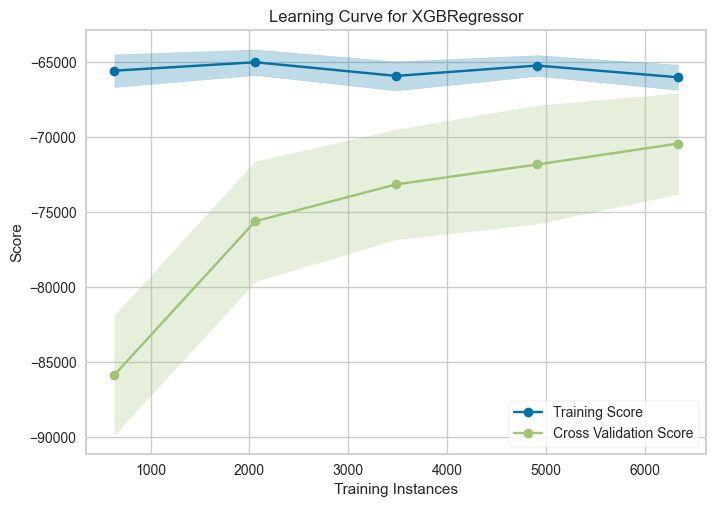

In [40]:
_ = ms.learning_curve(dart_xgb_electrical, X_train_electrical, y_train_electrical, scoring='neg_mean_squared_error', cv=5)

<Axes: >

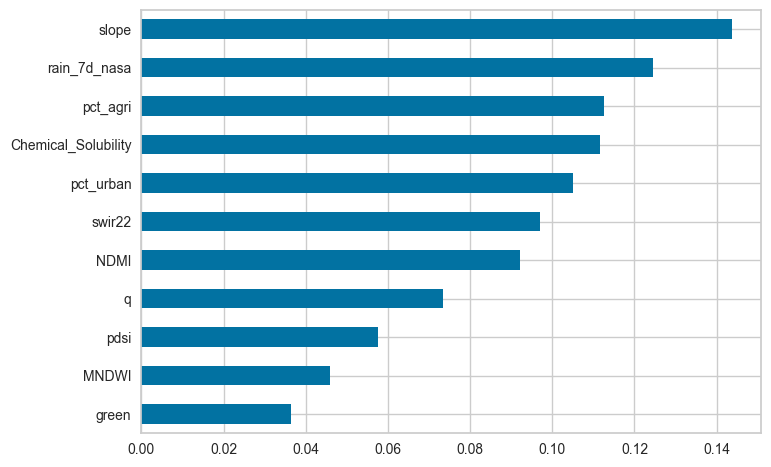

In [166]:
(pd.Series(dart_xgb_alcalinity.feature_importances_, index = X_train_alkalinity.columns).sort_values().plot.barh())


<Axes: >

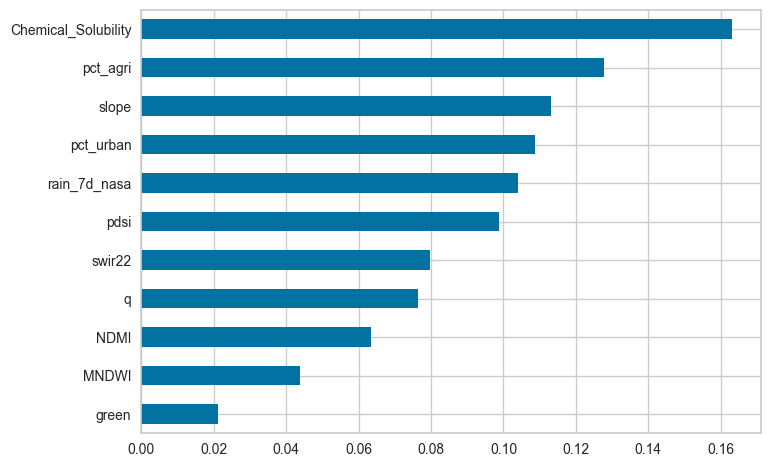

In [167]:

(pd.Series(dart_xgb_electrical.feature_importances_, index = X_train_electrical.columns).sort_values().plot.barh())


<Axes: >

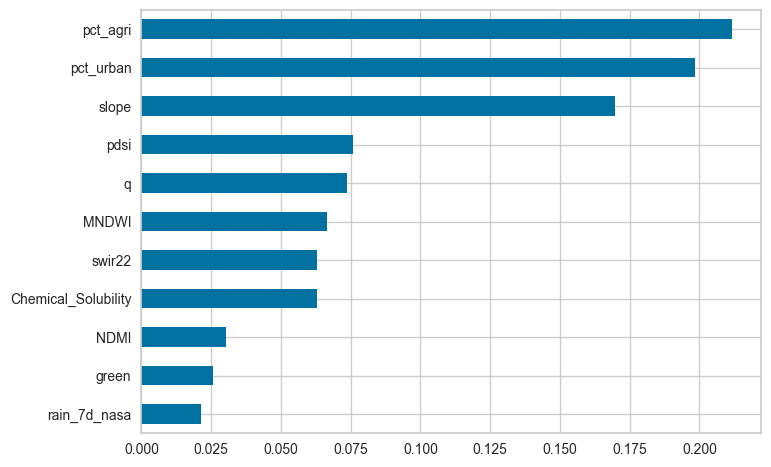

In [168]:

(pd.Series(dart_xgb_phosphorus.feature_importances_, index = X_train_phosphorus.columns).sort_values().plot.barh())

In [169]:
#make the print in green
print("\033[92mavaliando fosforo\033[0m")
evaluate_model(dart_xgb_phosphorus.predict(X_train_phosphorus), y_train_phosphorus, "train evaluation")
evaluate_model(dart_xgb_phosphorus.predict(X_test_phosphorus), y_test_phosphorus, "test evaluation")

print()
print("\033[92mavaliando alcalinidade\033[0m")
evaluate_model(dart_xgb_alcalinity.predict(X_train_alkalinity), y_train_alkalinity, "train evaluation")
evaluate_model(dart_xgb_alcalinity.predict(X_test_alkalinity), y_test_alkalinity, "test evaluation")

print()
print("\033[92mavaliando condutividade eletrica\033[0m")
evaluate_model(dart_xgb_electrical.predict(X_train_electrical), y_train_electrical, "train evaluation")
evaluate_model(dart_xgb_electrical.predict(X_test_electrical), y_test_electrical, "test evaluation")

avaliando fosforo

train evaluation Evaluation:
R²: 0.426
RMSE: 38.439

test evaluation Evaluation:
R²: 0.429
RMSE: 39.630

avaliando alcalinidade

train evaluation Evaluation:
R²: 0.506
RMSE: 52.684

test evaluation Evaluation:
R²: 0.492
RMSE: 52.251

avaliando condutividade eletrica

train evaluation Evaluation:
R²: 0.480
RMSE: 246.972

test evaluation Evaluation:
R²: 0.469
RMSE: 246.343


(array([543.9628 , 317.80103, 582.1867 , ..., 371.426  , 417.0313 ,
        340.69196], dtype=float32),
 0.469236190035748,
 np.float64(246.34285757493868))

## Submission

In [ ]:
submission_landsat_data = pd.read_csv("../Datasets/landsat_features_more_bands_validation.csv")
submission_terra_climate_data = pd.read_csv("../Datasets/terraclimate_features_more_bands_validation.csv")
submission_precipitation_data = pd.read_csv("../Datasets/nasa_precip_features_validation.csv")
submission_soil_use_data = pd.read_csv("../Datasets/soil_use_data_validation.csv")
submission_terrain_data = pd.read_csv("../Datasets/nasa_terrain_features_validation.csv")

all_submission_data = combine_two_datasets(submission_landsat_data, submission_terra_climate_data)
all_submission_data = combine_two_datasets(all_submission_data, submission_precipitation_data)
all_submission_data = combine_two_datasets(all_submission_data, submission_soil_use_data)
all_submission_data = combine_two_datasets(all_submission_data, submission_terrain_data)

all_submission_data = all_submission_data.drop(['soil', 'tmax', 'tmin'], axis=1)



all_submission_data['Sample Date'] = pd.to_datetime(all_submission_data['Sample Date'], dayfirst=True)
#all_submission_data['WeekOfYear'] = all_submission_data['Sample Date'].dt.isocalendar().week.astype(int)
all_submission_data['MonthOfYear'] = all_submission_data['Sample Date'].dt.month

MAX_CYCLE = 52
MAX_CYCLE_MONTH = 12

#all_submission_data['WOY_sin'] = np.sin(2 * np.pi * all_submission_data['WeekOfYear'] / MAX_CYCLE)
#all_submission_data['WOY_cos'] = np.cos(2 * np.pi * all_submission_data['WeekOfYear'] / MAX_CYCLE)
all_submission_data['Month_sin'] = np.sin(2 * np.pi * all_submission_data['MonthOfYear'] / MAX_CYCLE_MONTH)
all_submission_data['Month_cos'] = np.cos(2 * np.pi * all_submission_data['MonthOfYear'] / MAX_CYCLE_MONTH)

In [ ]:
X_pred_input_features_columns = all_submission_data.columns.drop(['Latitude', 'Longitude', 'Sample Date', 'MonthOfYear'])
X_pred_input_features = all_submission_data[X_pred_input_features_columns]



y_submission_pred_alkalinity = dart_xgb_alcalinity.predict(X_pred_input_features)
y_submission_pred_electrical = dart_xgb_electrical.predict(X_pred_input_features)
y_submission_pred_phosphorus = dart_xgb_phosphorus.predict(X_pred_input_features)

predicted_values_pd = pd.DataFrame({
    'Total Alkalinity': y_submission_pred_alkalinity, 
    'Electrical Conductance': y_submission_pred_electrical, 
    'Dissolved Reactive Phosphorus': y_submission_pred_phosphorus
})

predicted_pd = pd.DataFrame({
    'Latitude': all_submission_data['Latitude'].values,
    'Longitude': all_submission_data['Longitude'].values,
    'Sample Date': all_submission_data['Sample Date'].values,
})
predicted_pd = pd.concat([predicted_pd, predicted_values_pd], axis=1)
predicted_pd

predicted_pd.to_csv("../Results/submission_predictions_boosted_more_data.csv", index=False)
